`conda activate g5ht-pipeline` or `imgpro`

In [ ]:
import sys
import os
import importlib
from tqdm import tqdm
import h5py
import hdf5plugin
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import scipy.ndimage as ndi
import itk
import json

import matplotlib
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
matplotlib.rcParams['svg.fonttype'] = 'none'

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

from skimage.morphology import dilation

try:
    import utils
    is_torch_env = False
except ImportError:
    is_torch_env = True
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

In [ ]:
FIG_DIR = r"C:\Users\munib\POSTDOC\GRANTS\Jane Coffins\figs"

# DATA

In [ ]:
# DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\fluorescent_beads_ch_align\20251219'
DATA_PTH = r'D:\DATA\g5ht-free\20251028'

INPUT_ND2 = 'date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001.nd2'

INPUT_ND2_PTH = os.path.join(DATA_PTH, INPUT_ND2)

OUT_DIR = os.path.splitext(INPUT_ND2_PTH)[0]

BEHAV_H5 = os.path.join(DATA_PTH, os.path.splitext(INPUT_ND2)[0] + '.h5')

STACK_LENGTH = 41

num_frames, height, width, num_channels = utils.get_range_from_nd2(INPUT_ND2_PTH, stack_length=STACK_LENGTH) 

with h5py.File(BEHAV_H5, 'r') as f:
    behav_fps = 20.0
    behav_im = f.get('img_nir')[:] # THW
    behav_im_shape = behav_im.shape
    nframes = behav_im.shape[1]
    record_duration = nframes / behav_fps # in seconds
    time = np.arange(0, nframes, 1) / behav_fps  # in seconds
    time_str = [str(np.round(x,3)) + ' sec' for x in time]
    pos_stage = f.get('pos_stage')[:]  # shape (T, 2) , in microns
    pos_feature = f.get('pos_feature')[:]  # shape (T, 3, 3) , in microns. (time, x/y/conf, feat)

image_fps = 1/0.533

print(INPUT_ND2)
print(BEHAV_H5)
print('Num z-slices: ', STACK_LENGTH)
print('Number of frames: ', num_frames)
print('Height: ', height)
print('width: ', width)
print('Number of channels: ', num_channels)

# WORM TRAJECTORY AND SPEED

In [ ]:
plt, ax = utils.pretty_plot(figsize=(4.5,3))
sc = ax.scatter(pos_stage[:,0]/10000, pos_stage[:,1]/10000, c=np.arange(pos_stage.shape[0]) / behav_fps, cmap='viridis', s=5)
ax.set_xlabel('x-position (mm)')
ax.set_ylabel('y-position (mm)')
# time colorbar (provide the scatter mappable)
cbar = plt.colorbar(sc, label='Time (sec)')
# save as svg
plt.savefig(os.path.join(FIG_DIR, 'trajectory.svg'), format='svg', dpi=300)
plt.show()

In [ ]:

diffs = np.diff(pos_stage/10000, axis=0)  # shape (T-1, 2)
distances = np.sqrt(diffs[:,0]**2 + diffs[:,1]**2)  # in mm
time_diffs = 1.0 / behav_fps  # in seconds
speed = distances / time_diffs  # in mm per second
speed.shape

# smooth speed with a moving average filter, handle missing values appropriately
window_size = int(behav_fps)*4 # 1 second window
speed_smooth = np.convolve(speed, np.ones(window_size)/window_size, mode='same')
speed_smooth.shape
# handle missing values by interpolation   
speed_interp = np.interp(np.arange(len(speed)), np.arange(len(speed))[~np.isnan(speed)], speed[~np.isnan(speed)])
speed_smooth_interp = np.convolve(speed_interp, np.ones(window_size)/window_size, mode='same')
speed_smooth_interp.shape

plt, ax = utils.pretty_plot(figsize=(7,3))

# plt.figure()
ax.plot(np.arange(len(speed_smooth_interp))/behav_fps, speed_smooth_interp)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Movement speed (mm/sec)')
# save figure so that all elements are editable in adobe illustrator, so not png
plt.savefig(os.path.join(FIG_DIR, 'speed_over_time.svg'), format='svg', dpi=300)
plt.show()

# BEHAVIOR / FEATURE OVERLAY

In [ ]:
# plot a single frame with the pos_feature overlayed
index = 500
plt.figure(figsize=(5,5))
plt.imshow(behav_im[index], cmap='gray')
# overlay pos_feature for the first frame
plt.scatter(pos_feature[index,0,0], pos_feature[index,1,0], s=20)
plt.scatter(pos_feature[index,0,1], pos_feature[index,1,1], s=20)
plt.scatter(pos_feature[index,0,2], pos_feature[index,1,2], s=20)
# turn off the axes
plt.axis('off')
# save as svg
plt.savefig(os.path.join(FIG_DIR, 'pos_feature_overlay.svg'), format='svg', dpi=1000)
plt.show()


# ROI

In [ ]:
# load fixed.tif and roi.tif
tifffile_path = os.path.join(OUT_DIR, 'fixed.tif')
roi_path = os.path.join(OUT_DIR, 'roi.tif')
fixed = tifffile.imread(tifffile_path)[:,1,:,:]
roi = ndi.zoom(tifffile.imread(roi_path), zoom=(1/3,1,1))
fixed_roi = np.concatenate((fixed[np.newaxis,:,:,:], roi[np.newaxis,:,:,:]), axis=0)

In [ ]:
fixed_roi.shape

In [ ]:
# overlay fixed.tif and roi.tif for a single zslice with microshow
microshow(
    images=fixed[np.newaxis,15,:,:], cmaps=['red'], flip_map=False, fig_scaling=5, dpi=1000, rescale_type='limits', limits=[0,300],
    scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
    scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left')
plt.savefig(os.path.join(FIG_DIR, 'fixed_roi_overlay.svg'), format='svg', dpi=1000)
plt.show()


# ROI INTENSITY

In [ ]:
save = True

roi_intensity = np.genfromtxt(os.path.join(OUT_DIR,'quantified.csv'), delimiter=',')
roi_intensity = roi_intensity[1:,:]
roi_intensity

lw = 1

t = roi_intensity[:,0]

fig, ax = utils.pretty_plot(figsize=(8,3))
ax.plot(t, roi_intensity[:, 1] / np.mean(roi_intensity[:60, 1]), label='Dorsal nerve ring', lw=lw)
ax.plot(t, roi_intensity[:, 2] / np.mean(roi_intensity[:60, 2]), label='Ventral nerve ring', lw=lw)
ax.plot(t, roi_intensity[:, 3] / np.mean(roi_intensity[:60, 3]), label='Pharynx', lw=lw)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_xlabel('Time (min)')
ax.set_ylabel(r'$F/F_{baseline}$')
ax.set_xlim(t[0],t[-1])
ax.axhline(1, ls='--', c='k', zorder=0)
fig.tight_layout()
if save:
    plt.savefig(os.path.join(FIG_DIR, 'roi_intensity.svg'), dpi=300)
plt.show()

fig, ax = utils.pretty_plot(figsize=(8,3))
tend = 150
lw = 2
ax.plot(t[:tend], roi_intensity[:tend, 1] / np.mean(roi_intensity[:60, 1]), label='Dorsal nerve ring', lw=lw)
ax.plot(t[:tend], roi_intensity[:tend, 2] / np.mean(roi_intensity[:60, 2]), label='Ventral nerve ring', lw=lw)
ax.plot(t[:tend], roi_intensity[:tend, 3] / np.mean(roi_intensity[:60, 3]), label='Pharynx', lw=lw)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_xlabel('Time (min)')
ax.set_ylabel(r'$F/F_{baseline}$')
# ax.set_xlim(t[0],t[-1])
ax.axhline(1, ls='--', c='k', zorder=0)
fig.tight_layout()
if save:
    plt.savefig(os.path.join(FIG_DIR, 'roi_intensity_preencounter.svg'), dpi=300)
plt.show()


# DUAL COLOR IMAGING



In [ ]:
save = False

# load example frame, show gfp and rfp with microshow 
tifffile_path = os.path.join(OUT_DIR, 'tif', '1100.tif')
im = tifffile.imread(tifffile_path)


# select a single z-slice, show gfp and rfp with microshow
# zs = im[10,:,:,:]
# max intensity projection
zs = np.max(im, axis=0)

# # use elastix (itk) and align.txt in OUT_DIR to align the gfp channel to the rfp channel, then show with microshow
# zs_aligned = zs.copy()

# gfp = zs[0,:,:]
# parameter_object = itk.ParameterObject.New()
# parameter_object.ReadParameterFile(os.path.join(OUT_DIR, 'align.txt'))
# gfp = itk.transformix_filter(gfp, parameter_object)
# zs_aligned[0,:,:] = gfp

# microshow
microshow(zs, cmaps=['green', 'red'], flip_map=False, fig_scaling=5, dpi=1000, rescale_type='limits', limits=[[0,180],[0,500]],
    scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
    scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower right',
    channel_names=['g5-HT;GFP','mCherry'],
    channel_label_show=True, channel_label_size=0.05)
if save:
    plt.savefig(os.path.join(FIG_DIR, 'example_gfp_rfp.svg'), format='svg', dpi=1000)
plt.show()

# # microshow
# microshow(zs_aligned, cmaps=['green', 'red'], flip_map=False, fig_scaling=5, dpi=100, rescale_type='limits', limits=[[0,150],[0,300]],
#     scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
#     scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left')
# plt.savefig(os.path.join(FIG_DIR, 'example_gfp_rfp.svg'), format='svg', dpi=100)
# plt.show()

# REGISTRATION

In [ ]:

dpi = 1000


# load fixed frame and a unwarped tif
fixed_tifffile_path = os.path.join(OUT_DIR, 'fixed.tif')
unwarped_tifffile_path = os.path.join(OUT_DIR, 'tif', '0181.tif')
fixed = np.max(tifffile.imread(fixed_tifffile_path)[:,1,:,:], axis=0)
unwarped = np.max(tifffile.imread(unwarped_tifffile_path)[:,1,:,:], axis=0)

# read spline safely
with open(os.path.join(OUT_DIR, 'spline.json'), 'r') as fh:
    spline_dict = json.load(fh)
# ensure integer keys
spline_dict = {int(k): v for k, v in spline_dict.items()}
# pick key 181 if present, otherwise pick the first available frame
if 181 in spline_dict:
    spline = np.array(spline_dict[181])
else:
    spline = np.array(next(iter(spline_dict.values())))

# build perpendicular lines, skip degenerate segments where points are identical
perp_lines = []
for i in range(52, spline.shape[0] - 1):
    p1 = np.array(spline[i], dtype=float)
    p2 = np.array(spline[i + 1], dtype=float)
    v = p2 - p1
    v_len = np.linalg.norm(v)
    if v_len < 1e-6:
        continue
    v_norm = v / v_len
    perp_v = np.array([-v_norm[1], v_norm[0]])
    perp_v_scaled = perp_v * 100.0
    line_start = p1 - perp_v_scaled
    line_end = p1 + perp_v_scaled
    perp_lines.append((line_start, line_end))

# helper for safe colormap fraction
def cmap_frac(i, n):
    return float(i) / max(1, (n - 1))

# plot the spline on top of the unwarped image with microshow
microshow(images=unwarped[np.newaxis, :, :], cmaps=['red'], flip_map=False, fig_scaling=5, dpi=dpi,
          rescale_type='limits', limits=[0, 700],
          scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
          scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower right')
plt.savefig(os.path.join(FIG_DIR, 'unwarped_frame.svg'), format='svg', dpi=dpi  )
plt.show()

# overlay spline points and sampled perpendicular lines
microshow(images=unwarped[np.newaxis, :, :], cmaps=['red'], flip_map=False, fig_scaling=5, dpi=dpi,
          rescale_type='limits', limits=[0, 700],
          scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
          scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower right')

plt.plot(spline[52:, 1], spline[52:, 0], c='white', lw=1)

cmap = plt.get_cmap('winter')
skip = 10
sampled = perp_lines[::skip]
n_sampled = len(sampled)
for idx, (line_start, line_end) in enumerate(sampled):
    plt.plot([line_start[1], line_end[1]], [line_start[0], line_end[0]],
             c=cmap(cmap_frac(idx, n_sampled)), lw=1, alpha=0.7)

plt.savefig(os.path.join(FIG_DIR, 'unwarped_spline_overlay.svg'), format='svg', dpi=dpi)
plt.show()

# fixed frame
microshow(images=fixed[np.newaxis, :, :], cmaps=['red'], flip_map=False, fig_scaling=5, dpi=dpi,
          rescale_type='limits', limits=[0, 600],
          scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
          scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left')
plt.savefig(os.path.join(FIG_DIR, 'fixed_frame.svg'), format='svg', dpi=dpi)
plt.show()

# fixed frame with straightened vertical lines matching the number / order of sampled perpendiculars
microshow(images=fixed[np.newaxis, :, :], cmaps=['red'], flip_map=False, fig_scaling=5, dpi=dpi,
          rescale_type='limits', limits=[0, 600],
          scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
          scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left')

# reverse the colormap from the previous plot so the colors match the same lines on the unwarped frame
num_lines = max(0, n_sampled)
if num_lines > 0:
    # distribute lines evenly across the width, leaving 100-pixel margins
    if num_lines > 1:
        x_positions = np.linspace(0, fixed.shape[1], num_lines)
    else:
        x_positions = np.array([fixed.shape[1] / 2.0])
    for idx, x in enumerate(x_positions):
        plt.plot([x, x], [0, 200], c=cmap(1 - cmap_frac(idx, num_lines)), lw=1, alpha=0.7)



plt.savefig(os.path.join(FIG_DIR, 'fixed_spline_overlay.svg'), format='svg', dpi=dpi)
plt.show()


# EXAMPLE FIXED / MOVING WAPRED / REGISTERED

In [ ]:
save = False
dpi = 1000


# load fixed frame and a unwarped tif
fixed_tifffile_path = os.path.join(OUT_DIR, 'fixed.tif')
unwarped_tifffile_path = os.path.join(OUT_DIR, 'warped', '0190.tif')
registered_tifffile_path = os.path.join(OUT_DIR, 'registered', '0190.tif')
fixed = np.max(tifffile.imread(fixed_tifffile_path)[:,1,:,:], axis=0)
unwarped = np.max(tifffile.imread(unwarped_tifffile_path)[:,1,:,:], axis=0)
registered = np.max(tifffile.imread(registered_tifffile_path)[:,1,:,:], axis=0)

cat_unwarped = np.concatenate((fixed[np.newaxis,:,:], unwarped[np.newaxis,:,:]), axis=0)
cat_registered = np.concatenate((fixed[np.newaxis,:,:], registered[np.newaxis,:,:]), axis=0)

# plot the spline on top of the unwarped image with microshow
microshow(images=cat_unwarped, cmaps=['magenta','cyan'], flip_map=False, fig_scaling=5, dpi=dpi,
        rescale_type='limits', limits=[0, 700],
        scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
        scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left',
        channel_names=['Fixed','Moving'],
        channel_label_show=True, channel_label_size=0.05)
if save:
        plt.savefig(os.path.join(FIG_DIR, 'fixed_moving.svg'), format='svg', dpi=dpi  )
plt.show()

# plot the spline on top of the registered image with microshow
microshow(images=cat_registered, cmaps=['magenta','cyan'], flip_map=False, fig_scaling=5, dpi=dpi,
        rescale_type='limits', limits=[0, 700],
        scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
        scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left',
        channel_names=['Fixed','Registered'],
        channel_label_show=True, channel_label_size=0.05)
if save: 
        plt.savefig(os.path.join(FIG_DIR, 'fixed_registered.svg'), format='svg', dpi=dpi  )
plt.show()

# EXAMPLE FOOD ENCOUNTER ACTIVATION

In [ ]:
save = False
dpi = 1000


# load no signal frame, preencounter frame, postencounter frame, maximum intensity projection
no_signal = np.max(tifffile.imread(os.path.join(OUT_DIR, 'registered', '0003.tif'))[:,0,:,:], axis=0) # HW
preencounter = np.max(tifffile.imread(os.path.join(OUT_DIR, 'registered', '0100.tif'))[:,0,:,:], axis=0) # HW
postencounter = np.max(tifffile.imread(os.path.join(OUT_DIR, 'registered', '0180.tif'))[:,0,:,:], axis=0) # HW

mask = tifffile.imread(os.path.join(OUT_DIR, 'fixed_mask.tif'))

# apply mask to each of the frames
no_signal = no_signal * mask
preencounter = preencounter * mask
postencounter = postencounter * mask

microshow(images=no_signal[np.newaxis,:,:], cmaps=['green'], flip_map=False, fig_scaling=5, dpi=dpi,
        rescale_type='limits', limits=[0, 250],
        scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
        scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left')
if save:
        plt.savefig(os.path.join(FIG_DIR, 'no_food_g5.svg'), format='svg', dpi=dpi  )
plt.show()

microshow(images=preencounter[np.newaxis,:,:], cmaps=['green'], flip_map=False, fig_scaling=5, dpi=dpi,
        rescale_type='limits', limits=[0, 250],
        scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
        scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left')
if save:
        plt.savefig(os.path.join(FIG_DIR, 'pre_food_g5.svg'), format='svg', dpi=dpi  )
plt.show()

microshow(images=postencounter[np.newaxis,:,:], cmaps=['green'], flip_map=False, fig_scaling=5, dpi=dpi,
        rescale_type='limits', limits=[0, 250],
        scalebar_unit_per_pix=0.36, scalebar_thickness=0.01,
        scalebar_size_in_units=20, unit='um', scalebar_color='white', scalebar_location='lower left')
if save:
        plt.savefig(os.path.join(FIG_DIR, 'post_food_g5.svg'), format='svg', dpi=dpi  )
plt.show()

In [ ]:
mask.shape

# INTRO FIG SENSOR IMAGES

In [25]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt
import scipy.ndimage as ndi

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

frame = '0180'


DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

TIF_DIR = 'bleach_corrected_RFP_block'
# TIF_DIR = 'registered'

PTH = os.path.join(DATA_PTH, TIF_DIR, f'{frame}.tif')


# warped = ndi.zoom(tifffile.imread(WARP_PTH)[:,chan,:,:], zoom=(zoom,1,1)) # just the red channel (ZHW)

# delete im from memory
if 'im' in locals():
    del im
im = tifffile.imread(PTH)  # (ZCHW)
im = ndi.zoom(im, zoom=(3,1,1,1))

In [26]:
im.shape

(117, 2, 512, 512)

In [ ]:
# mip over z, x, y separately
mip_z = np.max(im, axis=0)  # (CHW)
mip_x = np.max(im, axis=2)  # (ZCH)
# transpose mip_z to CZW
mip_x = np.transpose(mip_x, (1,0,2))  # (CZW)
mip_y = np.max(im, axis=3)  # (ZCH)
# transpose mip_y to CZH
mip_y = np.transpose(mip_y, (1,0,2))  # (CZH)

print(mip_z.shape)
print(mip_x.shape)
print(mip_y.shape)

In [ ]:
# plot all mips with microfilm

mn = 0
mx = 600
# mx = 100
fs = 5

cmapg = 'green'
cmapr = 'red'

plot1 = microshow(
    images=mip_z, cmaps=[cmapg,cmapr], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[0, 255],[0,1500]])

plot1 = microshow(
    images=mip_y, cmaps=[cmapg,cmapr], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[0, 255],[0,1500]])



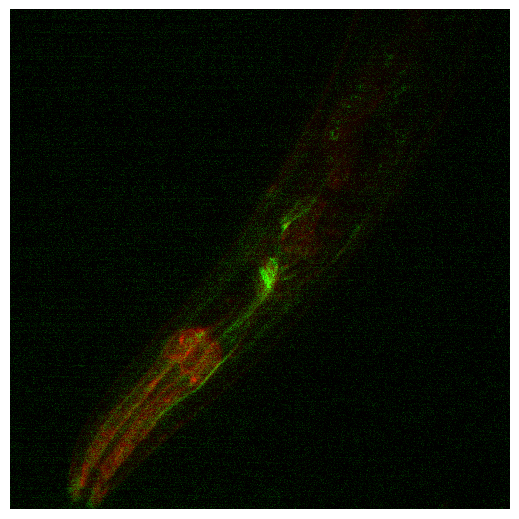

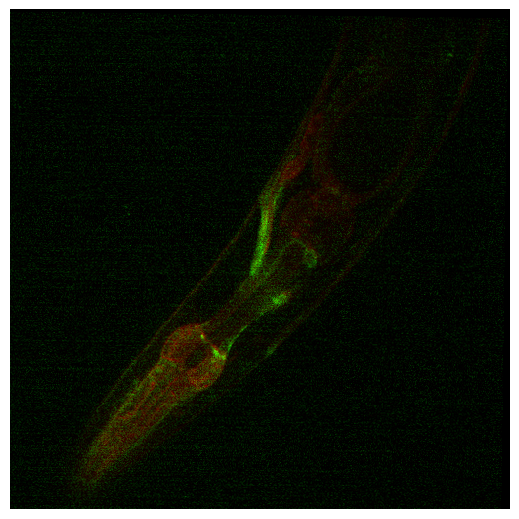

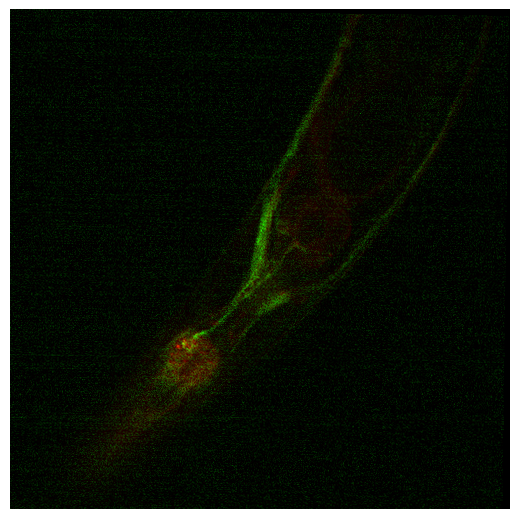

In [39]:
fs = 5
dpi = 100

# plot specified z slices with microshow
zs_to_plot = [18,40,55]
for zs in zs_to_plot:
    microshow(
        images=im[zs,:,:,:], cmaps=[cmapg,cmapr], flip_map=False, fig_scaling=fs, dpi=dpi,
        rescale_type='limits', limits=[[0, 200],[0,1500]])